# The transfer study

## Init

In [1]:
from itertools import product
from pathlib import Path

import numpy as np
import pandas as pd
import gymnasium as gym
from sb3_contrib import TQC
from huggingface_sb3 import load_from_hub

from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("pdf", "svg")

from pipoli.core import DimensionalPolicy, Dimension, Context, Policy
from pipoli.sources.sb3 import SB3Policy
from pipoli.evaluation import linsweep_change_contexts, linsweep_scale_contexts, scale_sweep_volume_bounds, record_sweep

from make_cheetah import make_cheetah, make_cheetah_xml

In [2]:
ROOT = Path() / "output"
XML_FILES = ROOT / "xml_files"
DATA = ROOT / "data"

In [3]:
class NaiveObsScaledActPolicy(Policy):

    def __init__(self, dim_pol, context, base):
        self.dim_pol = dim_pol
        self.context = context
        self.base = base
        act_dims = dim_pol.act_dims
        self.orig_to_adim, _ = dim_pol.context.make_transforms(act_dims, base)
        _, self.adim_to_scale = context.make_transforms(act_dims, base)
    
    def action(self, obs):
        """Scale only the action from a naive observation.
        
        Usually, the actuators of a system are sized accordingly. It would be
        unfair to not allow the policy to use the full range or allow it to use to much.
        """
        orig_act = self.dim_pol.action(obs)
        adim_act = self.orig_to_adim(orig_act)
        scaled_act = self.adim_to_scale(adim_act)
        return scaled_act

In [4]:
def make_env(context):
    torso_pos_z = context.value("torso_pos_z")
    xml_file = make_cheetah_xml(context, torso_pos_z, "env", outdir=XML_FILES)

    forward_weight = context.value("forward_reward_weight")
    ctrl_weight = context.value("ctrl_cost_weight")

    env = gym.make(
        "HalfCheetah-v5",
        xml_file=xml_file,
        forward_reward_weight=forward_weight,
        ctrl_cost_weight=ctrl_weight,
        reset_noise_scale=0,
    )
    
    return env

## Parameters

### Original context and policy

In [5]:
BASE_DIMENSIONS = [
    M := Dimension([1, 0, 0]),
    L := Dimension([0, 1, 0]),
    T := Dimension([0, 0, 1]),
]
Unit = Dimension([0, 0, 0])

In [6]:
original_context = Context.from_quantities(
    dt = 0.01                   | T,
    m = 14                      | M,
    g = 9.81                    | L/T**2,
    taumax = 1                  | M*L**2/T**2,
    d = 0.046                   | L,
    L = 0.5                     | L,
    Lh = 0.15                   | L,
    l0 = 0.145                  | L,
    l1 = 0.15                   | L,
    l2 = 0.094                  | L,
    l3 = 0.133                  | L,
    l4 = 0.106                  | L,
    l5 = 0.07                   | L,
    k0 = 240                    | M*L**2/T**2,
    k1 = 180                    | M*L**2/T**2,
    k2 = 120                    | M*L**2/T**2,
    k3 = 180                    | M*L**2/T**2,
    k4 = 120                    | M*L**2/T**2,
    k5 = 60                     | M*L**2/T**2,
    b0 = 6                      | M*L**2/T,
    b1 = 4.5                    | M*L**2/T,
    b2 = 3                      | M*L**2/T,
    b3 = 4.5                    | M*L**2/T,
    b4 = 3                      | M*L**2/T,
    b5 = 1.5                    | M*L**2/T,
    armature = 0.1              | M*L**2,
    damping = 0.01              | M*L**2/T,
    stiffness = 8               | M*L**2/T**2,
    forward_reward_weight = 1   | T/L,
    ctrl_cost_weight = 0.1      | T**4/M**2/L**4,
    torso_pos_z = 0.7           | L,
)

In [7]:
halfcheetah_v5_tqc_expert =  load_from_hub(
    repo_id="farama-minari/HalfCheetah-v5-TQC-expert",
    filename="halfcheetah-v5-TQC-expert.zip",
)
model = TQC.load(halfcheetah_v5_tqc_expert, device="cpu")

sb3_policy = SB3Policy(
    model,
    model_obs_space=gym.spaces.Box(-np.inf, np.inf, (17,), np.float64),
    model_act_space=gym.spaces.Box(-1.0, 1.0, (6,), np.float32),
    predict_kwargs=dict(deterministic=True)
)

original_policy = DimensionalPolicy(
    sb3_policy,
    original_context,
    obs_dims=[L] + [Unit] * 7 + [L/T] * 2 + [1/T] * 7,
    act_dims=[M*L**2/T**2] * 6
)

/home/pasf3302/Dev/transfer_halfcheetah/.venv/lib/python3.10/site-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code expected at most 16 arguments, got 18
  warnings.warn(


### Sweeps

In [ ]:
base = ["m", "L", "g"]
scale = 2
resolution = 27

similar_sweep_desc = dict(
    m = (14 / scale, 14 * scale, resolution),
    L = (0.5 / scale, 0.5 * scale, resolution),
    g = (9.81, 9.81, 1),
)

quasi_same_sweep_desc = dict(
    m = (14 / scale, 14 * scale, resolution),
    taumax = (1 / scale, 1 * scale, resolution),
)

quasi_similar_1_scale_sweep_desc = dict(
    m = (14 / scale, 14 * scale, resolution),
    L = (0.5, 0.5, 1),
    g = (9.81, 9.81, 1),
)
quasi_similar_1_change_sweep_desc = dict(
    taumax = (1 / scale, 1 * scale, resolution),
)

quasi_similar_2_scale_sweep_desc = dict(
    m = (14, 14, 1),
    L = (0.5 / scale, 0.5 * scale, resolution),
    g = (9.81, 9.81, 1),
)
quasi_similar_2_change_sweep_desc = dict(
    L = (0.5 / scale, 0.5 * scale, resolution),
)

nb_random_contexts = resolution * resolution

# bounds factors for random contexts around the original context
upper, lower = scale_sweep_volume_bounds(original_context, similar_sweep_desc)

upper /= original_context.values
lower /= original_context.values

upper[np.isnan(upper)] = 0
lower[np.isnan(lower)] = 0

### Functions

In [9]:
def make_scaled_policy(context):
    policy = original_policy.to_scaled(context, base)
    return policy

def make_semi_scaled_policy(context):
    policy = NaiveObsScaledActPolicy(original_policy, context, base)
    return policy

def make_naive_policy(_context):
    return original_policy

In [10]:
def ep_fn_extract_reward(act, step_res, _step):
    obs, rew, _, _, info = step_res

    fwd_rew = info["reward_forward"]
    ctrl_rew = info["reward_ctrl"]

    is_flipped = abs(obs[1]) > np.pi / 1.8

    return rew, fwd_rew, ctrl_rew, is_flipped

def ep_reduce_fn_total_reward(steps):
    nb_steps = len(steps)
    rews = np.zeros(nb_steps)
    fwds = np.zeros(nb_steps)
    ctrls = np.zeros(nb_steps)
    are_flipped = np.zeros(nb_steps, dtype=bool)

    for i, (rew, fwd, ctrl, is_flipped) in enumerate(steps):
        rews[i] = rew
        fwds[i] = fwd
        ctrls[i] = ctrl
        are_flipped[i] = is_flipped

    return rews.sum(), fwds.sum(), ctrls.sum(), int(any(are_flipped))

def fuse_fn(context_rec, ep_rec):
    _, _, reduction = ep_rec

    return context_rec + reduction

In [11]:
common_metadata = dict(
    base=base,
    original_context=original_context,
    original_policy=dict(
        repo_id="farama-minari/HalfCheetah-v5-TQC-expert",
        filename="halfcheetah-v5-TQC-expert.zip",
    ),
    env="HalfCheetah-v5",
)

## Similar transfer

### Data generation

In [12]:
def context_fn(context):
    b1 = context.value(base[0])
    b2 = context.value(base[1])
    b3 = context.value(base[2])
    distance = context.adimensional_distance(original_context, base)

    return context, b1, b2, b3, distance

In [13]:
all_similar_contexts = linsweep_scale_contexts(original_context, similar_sweep_desc)

In [14]:
columns = ["context", base[0], base[1], base[2], "distance", "reward", "fwd_reward", "ctrl_reward", "is_flipped"]

#### Scaled

In [15]:
data_scaled = record_sweep(
    all_similar_contexts,
    make_scaled_policy,
    make_env,
    context_fn=context_fn,
    ep_fn=ep_fn_extract_reward,
    ep_reduce_fn=ep_reduce_fn_total_reward,
    fuse_fn=fuse_fn
)
similar_scaled_df = pd.DataFrame(columns=columns, data=data_scaled)
similar_scaled_df

,context,m,L,g,distance,reward,fwd_reward,ctrl_reward,is_flipped
0,"((L, Dimension([0 1 0]), 0.25), (Lh, Dimension...",7.0,0.250000,9.81,0.000000e+00,16386.371950,16745.085071,-358.713121,0
1,"((L, Dimension([0 1 0]), 0.27884615384615385),...",7.0,0.278846,9.81,5.684613e-14,16386.371961,16745.085082,-358.713121,0
2,"((L, Dimension([0 1 0]), 0.3076923076923077), ...",7.0,0.307692,9.81,1.398579e-17,16386.371904,16745.085026,-358.713123,0
3,"((L, Dimension([0 1 0]), 0.33653846153846156),...",7.0,0.336538,9.81,5.552877e-16,16386.371951,16745.085072,-358.713121,0
4,"((L, Dimension([0 1 0]), 0.3653846153846154), ...",7.0,0.365385,9.81,1.387779e-17,16386.371916,16745.085035,-358.713119,0
...,...,...,...,...,...,...,...,...,...
724,"((L, Dimension([0 1 0]), 0.8846153846153847), ...",28.0,0.884615,9.81,0.000000e+00,16386.371983,16745.085108,-358.713125,0
725,"((L, Dimension([0 1 0]), 0.9134615384615385), ...",28.0,0.913462,9.81,3.469447e-18,16386.371998,16745.085117,-358.713119,0
726,"((L, Dimension([0 1 0]), 0.9423076923076923), ...",28.0,0.942308,9.81,0.000000e+00,16386.371999,16745.085121,-358.713122,0
727,"((L, Dimension([0 1 0]), 0.9711538461538461), ...",28.0,0.971154,9.81,6.938894e-17,16386.371876,16745.084999,-358.713123,0


#### Semi scaled

In [16]:
data_semi_scaled = record_sweep(
    all_similar_contexts,
    make_semi_scaled_policy,
    make_env,
    context_fn=context_fn,
    ep_fn=ep_fn_extract_reward,
    ep_reduce_fn=ep_reduce_fn_total_reward,
    fuse_fn=fuse_fn
)
similar_semi_scaled_df = pd.DataFrame(columns=columns, data=data_semi_scaled)
similar_semi_scaled_df

,context,m,L,g,distance,reward,fwd_reward,ctrl_reward,is_flipped
0,"((L, Dimension([0 1 0]), 0.25), (Lh, Dimension...",7.0,0.250000,9.81,0.000000e+00,2799.309707,3177.409512,-378.099804,0
1,"((L, Dimension([0 1 0]), 0.27884615384615385),...",7.0,0.278846,9.81,5.684613e-14,740.653966,841.530383,-100.876417,1
2,"((L, Dimension([0 1 0]), 0.3076923076923077), ...",7.0,0.307692,9.81,1.398579e-17,4483.013857,4851.996527,-368.982670,0
3,"((L, Dimension([0 1 0]), 0.33653846153846156),...",7.0,0.336538,9.81,5.552877e-16,1682.631168,1816.808533,-134.177364,1
4,"((L, Dimension([0 1 0]), 0.3653846153846154), ...",7.0,0.365385,9.81,1.387779e-17,6806.817987,7178.583546,-371.765560,0
...,...,...,...,...,...,...,...,...,...
724,"((L, Dimension([0 1 0]), 0.8846153846153847), ...",28.0,0.884615,9.81,0.000000e+00,-456.049936,12.386571,-468.436507,0
725,"((L, Dimension([0 1 0]), 0.9134615384615385), ...",28.0,0.913462,9.81,3.469447e-18,-46.960291,421.739465,-468.699755,0
726,"((L, Dimension([0 1 0]), 0.9423076923076923), ...",28.0,0.942308,9.81,0.000000e+00,-294.560068,139.325081,-433.885149,0
727,"((L, Dimension([0 1 0]), 0.9711538461538461), ...",28.0,0.971154,9.81,6.938894e-17,236.571191,658.483562,-421.912371,0


#### Naive

In [17]:
data_naive = record_sweep(
    all_similar_contexts,
    make_naive_policy,
    make_env,
    context_fn=context_fn,
    ep_fn=ep_fn_extract_reward,
    ep_reduce_fn=ep_reduce_fn_total_reward,
    fuse_fn=fuse_fn
)
similar_naive_df = pd.DataFrame(columns=columns, data=data_naive)
similar_naive_df

,context,m,L,g,distance,reward,fwd_reward,ctrl_reward,is_flipped
0,"((L, Dimension([0 1 0]), 0.25), (Lh, Dimension...",7.0,0.250000,9.81,0.000000e+00,-544.605548,2.923786,-547.529334,1
1,"((L, Dimension([0 1 0]), 0.27884615384615385),...",7.0,0.278846,9.81,5.684613e-14,-2008.000008,757.893455,-2765.893463,1
2,"((L, Dimension([0 1 0]), 0.3076923076923077), ...",7.0,0.307692,9.81,1.398579e-17,-220.906199,361.682608,-582.588808,1
3,"((L, Dimension([0 1 0]), 0.33653846153846156),...",7.0,0.336538,9.81,5.552877e-16,278.446049,2748.883580,-2470.437532,1
4,"((L, Dimension([0 1 0]), 0.3653846153846154), ...",7.0,0.365385,9.81,1.387779e-17,1077.549211,2798.250390,-1720.701180,1
...,...,...,...,...,...,...,...,...,...
724,"((L, Dimension([0 1 0]), 0.8846153846153847), ...",28.0,0.884615,9.81,0.000000e+00,-27.118534,0.127396,-27.245931,0
725,"((L, Dimension([0 1 0]), 0.9134615384615385), ...",28.0,0.913462,9.81,3.469447e-18,-26.195951,-0.066588,-26.129363,0
726,"((L, Dimension([0 1 0]), 0.9423076923076923), ...",28.0,0.942308,9.81,0.000000e+00,-25.089297,-0.035109,-25.054188,0
727,"((L, Dimension([0 1 0]), 0.9711538461538461), ...",28.0,0.971154,9.81,6.938894e-17,-23.655296,-0.328299,-23.326997,0


### Analysis

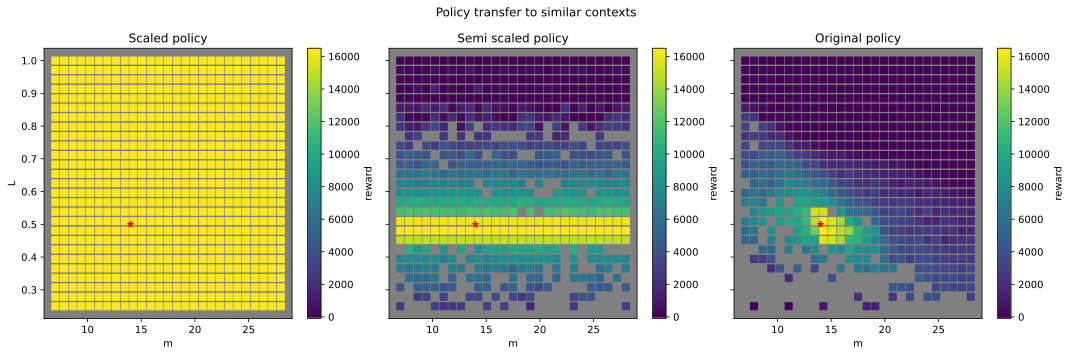

In [47]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 5))

m0 = original_context.value("m")
L0 = original_context.value("L")

norm = mpl.colors.Normalize(vmin=-100, vmax=16500)

similar_scaled_df.loc[similar_scaled_df["is_flipped"] == 0].plot.scatter("m", "L", c="reward", marker="s", s=50, norm=norm, ax=ax1)
ax1.scatter(m0, L0, marker="*", c="r")
ax1.set_title("Scaled policy")
ax1.set_facecolor("grey")

similar_semi_scaled_df.loc[similar_semi_scaled_df["is_flipped"] == 0].plot.scatter("m", "L", c="reward", marker="s", s=50, norm=norm, ax=ax2)
ax2.scatter(m0, L0, marker="*", c="r")
ax2.set_title("Semi scaled policy")
ax2.set_facecolor("grey")

similar_naive_df.loc[similar_naive_df["is_flipped"] == 0].plot.scatter("m", "L", c="reward", marker="s", s=50, norm=norm, ax=ax3)
ax3.scatter(m0, L0, marker="*", c="r")
ax3.set_title("Original policy")
ax3.set_facecolor("grey")

fig.suptitle("Policy transfer to similar contexts")
fig.set_tight_layout(True)

## Quasi same transfer

### Data generation

In [19]:
def context_fn(context):
    b1 = context.value(base[0])
    b2 = context.value(base[1])
    b3 = context.value(base[2])
    distance = context.adimensional_distance(original_context, base)

    change = []
    for sym in quasi_same_sweep_desc.keys():
        if sym not in base:
            change.append(context.value(sym))

    return context, b1, b2, b3, *change, distance

In [20]:
changed_symbols = []
for sym in quasi_same_sweep_desc.keys():
    if sym not in base:
        changed_symbols.append(sym)

columns = ["context", base[0], base[1], base[2], *changed_symbols, "distance", "reward", "fwd_reward", "ctrl_reward", "is_flipped"]

In [21]:
all_quasi_same_contexts = linsweep_change_contexts(original_context, quasi_same_sweep_desc)

#### Scaled

In [22]:
data_scaled = record_sweep(
    all_quasi_same_contexts,
    make_scaled_policy,
    make_env,
    context_fn=context_fn,
    ep_fn=ep_fn_extract_reward,
    ep_reduce_fn=ep_reduce_fn_total_reward,
    fuse_fn=fuse_fn
)
quasi_same_scaled_df = pd.DataFrame(columns=columns, data=data_scaled)
quasi_same_scaled_df

,context,m,L,g,taumax,distance,reward,fwd_reward,ctrl_reward,is_flipped
0,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",7.0,0.5,9.81,0.500000,353.714664,1593.359363,1687.129375,-93.770011,0
1,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",7.0,0.5,9.81,0.557692,353.714664,1593.359363,1687.129375,-93.770011,0
2,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",7.0,0.5,9.81,0.615385,353.714664,1593.359363,1687.129375,-93.770011,0
3,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",7.0,0.5,9.81,0.673077,353.714664,1593.359363,1687.129375,-93.770011,0
4,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",7.0,0.5,9.81,0.730769,353.714664,1593.359363,1687.129375,-93.770011,0
...,...,...,...,...,...,...,...,...,...,...
724,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",28.0,0.5,9.81,1.769231,1414.673607,366.526440,667.369587,-300.843147,1
725,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",28.0,0.5,9.81,1.826923,1414.673607,2537.069859,3415.759986,-878.690127,1
726,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",28.0,0.5,9.81,1.884615,1414.673607,2406.689434,3189.503427,-782.813993,1
727,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",28.0,0.5,9.81,1.942308,1414.673607,5011.033515,6610.600432,-1599.566917,0


#### Semi scaled

In [23]:
data_semi_scaled = record_sweep(
    all_quasi_same_contexts,
    make_semi_scaled_policy,
    make_env,
    context_fn=context_fn,
    ep_fn=ep_fn_extract_reward,
    ep_reduce_fn=ep_reduce_fn_total_reward,
    fuse_fn=fuse_fn
)
quasi_same_semi_scaled_df = pd.DataFrame(columns=columns, data=data_semi_scaled)
quasi_same_semi_scaled_df

,context,m,L,g,taumax,distance,reward,fwd_reward,ctrl_reward,is_flipped
0,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",7.0,0.5,9.81,0.500000,353.714664,1593.359363,1687.129375,-93.770011,0
1,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",7.0,0.5,9.81,0.557692,353.714664,1593.359363,1687.129375,-93.770011,0
2,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",7.0,0.5,9.81,0.615385,353.714664,1593.359363,1687.129375,-93.770011,0
3,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",7.0,0.5,9.81,0.673077,353.714664,1593.359363,1687.129375,-93.770011,0
4,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",7.0,0.5,9.81,0.730769,353.714664,1593.359363,1687.129375,-93.770011,0
...,...,...,...,...,...,...,...,...,...,...
724,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",28.0,0.5,9.81,1.769231,1414.673607,366.526440,667.369587,-300.843147,1
725,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",28.0,0.5,9.81,1.826923,1414.673607,2537.069859,3415.759986,-878.690127,1
726,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",28.0,0.5,9.81,1.884615,1414.673607,2406.689434,3189.503427,-782.813993,1
727,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",28.0,0.5,9.81,1.942308,1414.673607,5011.033515,6610.600432,-1599.566917,0


#### Naive

In [24]:
data_naive = record_sweep(
    all_quasi_same_contexts,
    make_naive_policy,
    make_env,
    context_fn=context_fn,
    ep_fn=ep_fn_extract_reward,
    ep_reduce_fn=ep_reduce_fn_total_reward,
    fuse_fn=fuse_fn
)
quasi_same_naive_df = pd.DataFrame(columns=columns, data=data_naive)
quasi_same_naive_df

,context,m,L,g,taumax,distance,reward,fwd_reward,ctrl_reward,is_flipped
0,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",7.0,0.5,9.81,0.500000,353.714664,253.333957,304.295605,-50.961648,1
1,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",7.0,0.5,9.81,0.557692,353.714664,2498.936928,2867.453447,-368.516519,1
2,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",7.0,0.5,9.81,0.615385,353.714664,4579.843627,4947.120657,-367.277030,1
3,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",7.0,0.5,9.81,0.673077,353.714664,4654.378373,5040.493362,-386.114989,0
4,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",7.0,0.5,9.81,0.730769,353.714664,182.597414,206.842924,-24.245510,1
...,...,...,...,...,...,...,...,...,...,...
724,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",28.0,0.5,9.81,1.769231,1414.673607,3457.491988,3839.633672,-382.141684,0
725,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",28.0,0.5,9.81,1.826923,1414.673607,3457.491988,3839.633672,-382.141684,0
726,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",28.0,0.5,9.81,1.884615,1414.673607,3457.491988,3839.633672,-382.141684,0
727,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",28.0,0.5,9.81,1.942308,1414.673607,3457.491988,3839.633672,-382.141684,0


### Analysis


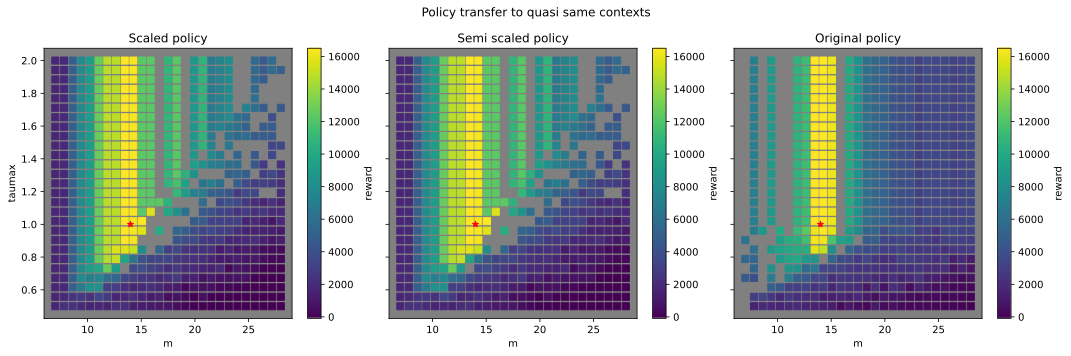

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 5))

m0 = original_context.value("m")
tau0 = original_context.value("taumax")

norm = mpl.colors.Normalize(vmin=-100, vmax=16500)

quasi_same_scaled_df.loc[quasi_same_scaled_df["is_flipped"] == 0].plot.scatter("m", "taumax", c="reward", marker="s", s=50, norm=norm, ax=ax1)
# quasi_same_scaled_df.plot.scatter("m", "taumax", c="reward", marker="s", s=50, norm=norm, ax=ax1)
ax1.scatter(m0, tau0, marker="*", c="r")
ax1.set_title("Scaled policy")
ax1.set_facecolor("grey")

quasi_same_semi_scaled_df.loc[quasi_same_semi_scaled_df["is_flipped"] == 0].plot.scatter("m", "taumax", c="reward", marker="s", s=50, norm=norm, ax=ax2)
# quasi_same_semi_scaled_df.plot.scatter("m", "taumax", c="reward", marker="s", s=50, norm=norm, ax=ax2)
ax2.scatter(m0, tau0, marker="*", c="r")
ax2.set_title("Semi scaled policy")
ax2.set_facecolor("grey")

quasi_same_naive_df.loc[quasi_same_naive_df["is_flipped"] == 0].plot.scatter("m", "taumax", c="reward", marker="s", s=50, norm=norm, ax=ax3)
# quasi_same_naive_df.plot.scatter("m", "taumax", c="reward", marker="s", s=50, norm=norm, ax=ax3)
ax3.scatter(m0, tau0, marker="*", c="r")
ax3.set_title("Original policy")
ax3.set_facecolor("grey")

fig.suptitle("Policy transfer to quasi same contexts")
fig.set_tight_layout(True)

## Quasi similar transfer 1

### Data generation

In [26]:
def context_fn(context):
    b1 = context.value(base[0])
    b2 = context.value(base[1])
    b3 = context.value(base[2])
    distance = context.adimensional_distance(original_context, base)

    change = []
    for sym in quasi_similar_1_change_sweep_desc.keys():
        if sym not in base:
            change.append(context.value(sym))

    return context, b1, b2, b3, *change, distance

In [27]:
changed_symbols = []
for sym in quasi_similar_1_change_sweep_desc.keys():
    if sym not in base:
        changed_symbols.append(sym)

columns = ["context", base[0], base[1], base[2], *changed_symbols, "distance", "reward", "fwd_reward", "ctrl_reward", "is_flipped"]

In [28]:
# map change(taumax) linsweep_scale_contexts(mgl)
all_quasi_similar_1_contexts = []

similars = linsweep_scale_contexts(original_context, quasi_similar_1_scale_sweep_desc)
for context in similars:
    all_quasi_similar_1_contexts += linsweep_change_contexts(context, quasi_similar_1_change_sweep_desc)

#### Scaled

In [29]:
data_scaled = record_sweep(
    all_quasi_similar_1_contexts,
    make_scaled_policy,
    make_env,
    context_fn=context_fn,
    ep_fn=ep_fn_extract_reward,
    ep_reduce_fn=ep_reduce_fn_total_reward,
    fuse_fn=fuse_fn
)
quasi_similar_1_scaled_df = pd.DataFrame(columns=columns, data=data_scaled)
quasi_similar_1_scaled_df

,context,m,L,g,taumax,distance,reward,fwd_reward,ctrl_reward,is_flipped
0,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",7.0,0.5,9.81,0.500000,0.000000,16386.371966,16745.085086,-358.713119,0
1,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",7.0,0.5,9.81,0.557692,0.001680,16386.371966,16745.085086,-358.713119,0
2,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",7.0,0.5,9.81,0.615385,0.003361,16386.371966,16745.085086,-358.713119,0
3,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",7.0,0.5,9.81,0.673077,0.005041,16386.371966,16745.085086,-358.713119,0
4,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",7.0,0.5,9.81,0.730769,0.006721,16386.371966,16745.085086,-358.713119,0
...,...,...,...,...,...,...,...,...,...,...
724,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",28.0,0.5,9.81,1.769231,0.001680,16382.117968,16743.972432,-361.854464,0
725,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",28.0,0.5,9.81,1.826923,0.001260,17067.916342,17431.788402,-363.872060,0
726,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",28.0,0.5,9.81,1.884615,0.000840,17176.592725,17540.671668,-364.078943,0
727,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",28.0,0.5,9.81,1.942308,0.000420,16380.847973,16739.577105,-358.729132,0


#### Semi scaled

In [30]:
data_semi_scaled = record_sweep(
    all_quasi_similar_1_contexts,
    make_semi_scaled_policy,
    make_env,
    context_fn=context_fn,
    ep_fn=ep_fn_extract_reward,
    ep_reduce_fn=ep_reduce_fn_total_reward,
    fuse_fn=fuse_fn
)
quasi_similar_1_semi_scaled_df = pd.DataFrame(columns=columns, data=data_semi_scaled)
quasi_similar_1_semi_scaled_df

,context,m,L,g,taumax,distance,reward,fwd_reward,ctrl_reward,is_flipped
0,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",7.0,0.5,9.81,0.500000,0.000000,16386.371966,16745.085086,-358.713119,0
1,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",7.0,0.5,9.81,0.557692,0.001680,16386.371966,16745.085086,-358.713119,0
2,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",7.0,0.5,9.81,0.615385,0.003361,16386.371966,16745.085086,-358.713119,0
3,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",7.0,0.5,9.81,0.673077,0.005041,16386.371966,16745.085086,-358.713119,0
4,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",7.0,0.5,9.81,0.730769,0.006721,16386.371966,16745.085086,-358.713119,0
...,...,...,...,...,...,...,...,...,...,...
724,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",28.0,0.5,9.81,1.769231,0.001680,16382.117968,16743.972432,-361.854464,0
725,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",28.0,0.5,9.81,1.826923,0.001260,17067.916342,17431.788402,-363.872060,0
726,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",28.0,0.5,9.81,1.884615,0.000840,17176.592725,17540.671668,-364.078943,0
727,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",28.0,0.5,9.81,1.942308,0.000420,16380.847973,16739.577105,-358.729132,0


#### Naive

In [31]:
data_naive = record_sweep(
    all_quasi_similar_1_contexts,
    make_naive_policy,
    make_env,
    context_fn=context_fn,
    ep_fn=ep_fn_extract_reward,
    ep_reduce_fn=ep_reduce_fn_total_reward,
    fuse_fn=fuse_fn
)
quasi_similar_1_naive_df = pd.DataFrame(columns=columns, data=data_naive)
quasi_similar_1_naive_df

,context,m,L,g,taumax,distance,reward,fwd_reward,ctrl_reward,is_flipped
0,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",7.0,0.5,9.81,0.500000,0.000000,3272.211421,4223.007840,-950.796419,1
1,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",7.0,0.5,9.81,0.557692,0.001680,1260.020183,1751.966219,-491.946035,1
2,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",7.0,0.5,9.81,0.615385,0.003361,4111.838258,5331.795801,-1219.957544,1
3,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",7.0,0.5,9.81,0.673077,0.005041,1285.605320,1823.648146,-538.042827,1
4,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",7.0,0.5,9.81,0.730769,0.006721,1381.513211,1824.979102,-443.465891,1
...,...,...,...,...,...,...,...,...,...,...
724,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",28.0,0.5,9.81,1.769231,0.001680,1473.592703,1572.358062,-98.765359,0
725,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",28.0,0.5,9.81,1.826923,0.001260,1473.592703,1572.358062,-98.765359,0
726,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",28.0,0.5,9.81,1.884615,0.000840,1473.592703,1572.358062,-98.765359,0
727,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",28.0,0.5,9.81,1.942308,0.000420,1473.592703,1572.358062,-98.765359,0


### Analysis


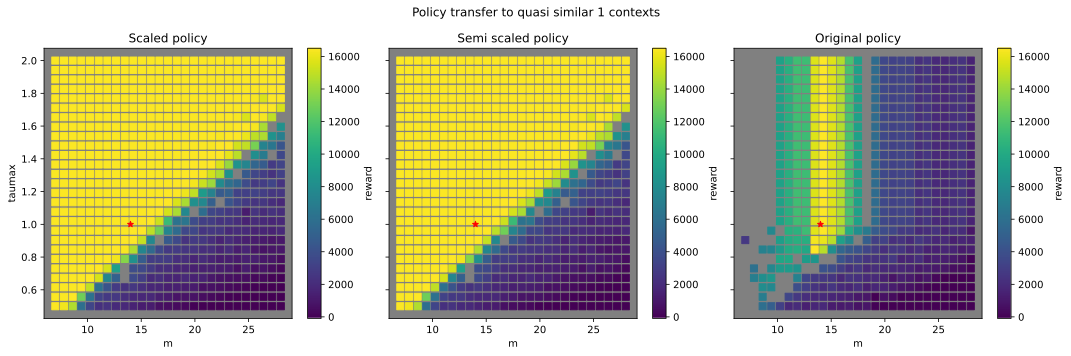

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 5))

m0 = original_context.value("m")
tau0 = original_context.value("taumax")

norm = mpl.colors.Normalize(vmin=-100, vmax=16500)

quasi_similar_1_scaled_df.loc[quasi_similar_1_scaled_df["is_flipped"] == 0].plot.scatter("m", "taumax", c="reward", marker="s", s=50, norm=norm, ax=ax1)
# quasi_similar_1_scaled_df.plot.scatter("m", "taumax", c="reward", marker="s", s=50, norm=norm, ax=ax1)
ax1.scatter(m0, tau0, marker="*", c="r")
ax1.set_title("Scaled policy")
ax1.set_facecolor("grey")

quasi_similar_1_semi_scaled_df.loc[quasi_similar_1_semi_scaled_df["is_flipped"] == 0].plot.scatter("m", "taumax", c="reward", marker="s", s=50, norm=norm, ax=ax2)
# quasi_similar_1_semi_scaled_df.plot.scatter("m", "taumax", c="reward", marker="s", s=50, norm=norm, ax=ax2)
ax2.scatter(m0, tau0, marker="*", c="r")
ax2.set_title("Semi scaled policy")
ax2.set_facecolor("grey")

quasi_similar_1_naive_df.loc[quasi_similar_1_naive_df["is_flipped"] == 0].plot.scatter("m", "taumax", c="reward", marker="s", s=50, norm=norm, ax=ax3)
# quasi_similar_1_naive_df.plot.scatter("m", "taumax", c="reward", marker="s", s=50, norm=norm, ax=ax3)
ax3.scatter(m0, tau0, marker="*", c="r")
ax3.set_title("Original policy")
ax3.set_facecolor("grey")

fig.suptitle("Policy transfer to quasi similar 1 contexts")
fig.set_tight_layout(True)

## Quasi similar transfer 2

### Data generation

In [33]:
def context_fn(context):
    b1 = context.value(base[0])
    b2 = context.value(base[1])
    b3 = context.value(base[2])
    distance = context.adimensional_distance(original_context, base)

    change = [context.value("torso_pos_z")]
    # for sym in quasi_similar_1_change_sweep_desc.keys():
    #     if sym not in base:
    #         change.append(context.value(sym))

    return context, b1, b2, b3, *change, distance

In [34]:
changed_symbols = ["torso_pos_z"]
# for sym in quasi_similar_1_change_sweep_desc.keys():
#     if sym not in base:
#         changed_symbols.append(sym)

columns = ["context", base[0], base[1], base[2], *changed_symbols, "distance", "reward", "fwd_reward", "ctrl_reward", "is_flipped"]

In [35]:
# map change(taumax) linsweep_scale_contexts(mgl)
all_quasi_similar_2_contexts = []

similars = linsweep_scale_contexts(original_context, quasi_similar_2_scale_sweep_desc)
for context in similars:
    all_quasi_similar_2_contexts += linsweep_change_contexts(context, quasi_similar_2_change_sweep_desc)

#### Scaled

In [36]:
data_scaled = record_sweep(
    all_quasi_similar_2_contexts,
    make_scaled_policy,
    make_env,
    context_fn=context_fn,
    ep_fn=ep_fn_extract_reward,
    ep_reduce_fn=ep_reduce_fn_total_reward,
    fuse_fn=fuse_fn
)
quasi_similar_2_scaled_df = pd.DataFrame(columns=columns, data=data_scaled)
quasi_similar_2_scaled_df

,context,m,L,g,torso_pos_z,distance,reward,fwd_reward,ctrl_reward,is_flipped
0,"((L, Dimension([0 1 0]), 0.25), (Lh, Dimension...",14.0,0.250000,9.81,0.35,0.000000,16386.371907,16745.085028,-358.713121,0
1,"((L, Dimension([0 1 0]), 0.27884615384615385),...",14.0,0.278846,9.81,0.35,115.100691,8155.701395,8629.992572,-474.291177,0
2,"((L, Dimension([0 1 0]), 0.3076923076923077), ...",14.0,0.307692,9.81,0.35,242.756871,5949.972445,6513.768783,-563.796338,0
3,"((L, Dimension([0 1 0]), 0.33653846153846156),...",14.0,0.336538,9.81,0.35,382.968856,4209.965347,4871.485775,-661.520428,0
4,"((L, Dimension([0 1 0]), 0.3653846153846154), ...",14.0,0.365385,9.81,0.35,535.736823,310.407214,428.820652,-118.413438,1
...,...,...,...,...,...,...,...,...,...,...
724,"((L, Dimension([0 1 0]), 0.8846153846153847), ...",14.0,0.884615,9.81,1.40,102.545785,7006.412234,7336.191134,-329.778900,0
725,"((L, Dimension([0 1 0]), 0.9134615384615385), ...",14.0,0.913462,9.81,1.40,78.086312,7770.668003,8102.522638,-331.854635,1
726,"((L, Dimension([0 1 0]), 0.9423076923076923), ...",14.0,0.942308,9.81,1.40,52.842202,15833.132188,16159.826574,-326.694386,0
727,"((L, Dimension([0 1 0]), 0.9711538461538461), ...",14.0,0.971154,9.81,1.40,26.813437,16873.830044,17211.853786,-338.023742,0


#### Semi scaled

In [37]:
data_semi_scaled = record_sweep(
    all_quasi_similar_2_contexts,
    make_semi_scaled_policy,
    make_env,
    context_fn=context_fn,
    ep_fn=ep_fn_extract_reward,
    ep_reduce_fn=ep_reduce_fn_total_reward,
    fuse_fn=fuse_fn
)
quasi_similar_2_semi_scaled_df = pd.DataFrame(columns=columns, data=data_semi_scaled)
quasi_similar_2_semi_scaled_df

,context,m,L,g,torso_pos_z,distance,reward,fwd_reward,ctrl_reward,is_flipped
0,"((L, Dimension([0 1 0]), 0.25), (Lh, Dimension...",14.0,0.250000,9.81,0.35,0.000000,672.570830,795.199362,-122.628532,1
1,"((L, Dimension([0 1 0]), 0.27884615384615385),...",14.0,0.278846,9.81,0.35,115.100691,1882.397962,2356.805273,-474.407310,0
2,"((L, Dimension([0 1 0]), 0.3076923076923077), ...",14.0,0.307692,9.81,0.35,242.756871,1274.743473,1848.527103,-573.783631,0
3,"((L, Dimension([0 1 0]), 0.33653846153846156),...",14.0,0.336538,9.81,0.35,382.968856,1119.576409,1810.476511,-690.900102,0
4,"((L, Dimension([0 1 0]), 0.3653846153846154), ...",14.0,0.365385,9.81,0.35,535.736823,1175.288352,1970.877923,-795.589571,0
...,...,...,...,...,...,...,...,...,...,...
724,"((L, Dimension([0 1 0]), 0.8846153846153847), ...",14.0,0.884615,9.81,1.40,102.545785,-307.199514,34.137369,-341.336882,0
725,"((L, Dimension([0 1 0]), 0.9134615384615385), ...",14.0,0.913462,9.81,1.40,78.086312,-322.908885,31.563129,-354.472014,0
726,"((L, Dimension([0 1 0]), 0.9423076923076923), ...",14.0,0.942308,9.81,1.40,52.842202,283.596816,638.072856,-354.476040,0
727,"((L, Dimension([0 1 0]), 0.9711538461538461), ...",14.0,0.971154,9.81,1.40,26.813437,289.947115,660.730344,-370.783229,0


#### Naive

In [38]:
data_naive = record_sweep(
    all_quasi_similar_2_contexts,
    make_naive_policy,
    make_env,
    context_fn=context_fn,
    ep_fn=ep_fn_extract_reward,
    ep_reduce_fn=ep_reduce_fn_total_reward,
    fuse_fn=fuse_fn
)
quasi_similar_2_naive_df = pd.DataFrame(columns=columns, data=data_naive)
quasi_similar_2_naive_df

,context,m,L,g,torso_pos_z,distance,reward,fwd_reward,ctrl_reward,is_flipped
0,"((L, Dimension([0 1 0]), 0.25), (Lh, Dimension...",14.0,0.250000,9.81,0.35,0.000000,137.319646,665.144657,-527.825011,1
1,"((L, Dimension([0 1 0]), 0.27884615384615385),...",14.0,0.278846,9.81,0.35,115.100691,275.151954,780.923267,-505.771313,1
2,"((L, Dimension([0 1 0]), 0.3076923076923077), ...",14.0,0.307692,9.81,0.35,242.756871,266.956050,1223.851156,-956.895106,1
3,"((L, Dimension([0 1 0]), 0.33653846153846156),...",14.0,0.336538,9.81,0.35,382.968856,130.528323,1677.250519,-1546.722196,0
4,"((L, Dimension([0 1 0]), 0.3653846153846154), ...",14.0,0.365385,9.81,0.35,535.736823,256.566716,1744.541885,-1487.975170,0
...,...,...,...,...,...,...,...,...,...,...
724,"((L, Dimension([0 1 0]), 0.8846153846153847), ...",14.0,0.884615,9.81,1.40,102.545785,-136.765613,-53.702199,-83.063413,0
725,"((L, Dimension([0 1 0]), 0.9134615384615385), ...",14.0,0.913462,9.81,1.40,78.086312,-166.959300,-83.085863,-83.873437,0
726,"((L, Dimension([0 1 0]), 0.9423076923076923), ...",14.0,0.942308,9.81,1.40,52.842202,-149.304033,-65.045520,-84.258512,0
727,"((L, Dimension([0 1 0]), 0.9711538461538461), ...",14.0,0.971154,9.81,1.40,26.813437,-163.362895,-78.119758,-85.243138,0


### Analysis


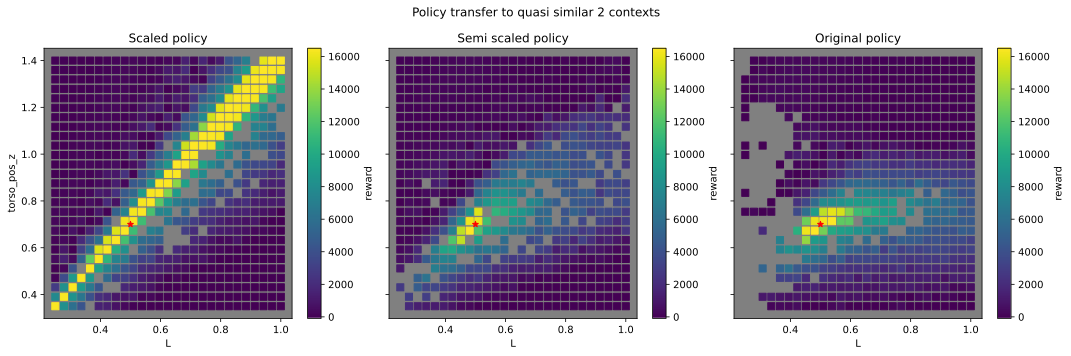

In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 5))

L = original_context.value("L")
pos_z = original_context.value("torso_pos_z")

norm = mpl.colors.Normalize(vmin=-100, vmax=16500)

quasi_similar_2_scaled_df.loc[quasi_similar_2_scaled_df["is_flipped"] == 0].plot.scatter("L", "torso_pos_z", c="reward", marker="s", s=50, norm=norm, ax=ax1)
# quasi_similar_2_scaled_df.plot.scatter("L", "torso_pos_z" c="reward", marker="s", s=50, norm=norm, ax=ax1)
ax1.scatter(L, pos_z, marker="*", c="r")
ax1.set_title("Scaled policy")
ax1.set_facecolor("grey")

quasi_similar_2_semi_scaled_df.loc[quasi_similar_2_semi_scaled_df["is_flipped"] == 0].plot.scatter("L", "torso_pos_z", c="reward", marker="s", s=50, norm=norm, ax=ax2)
# quasi_similar_2_semi_scaled_df.plot.scatter("L", "torso_pos_z", c="reward", marker="s", s=50, norm=norm, ax=ax2)
ax2.scatter(L, pos_z, marker="*", c="r")
ax2.set_title("Semi scaled policy")
ax2.set_facecolor("grey")

quasi_similar_2_naive_df.loc[quasi_similar_2_naive_df["is_flipped"] == 0].plot.scatter("L", "torso_pos_z", c="reward", marker="s", s=50, norm=norm, ax=ax3)
# quasi_similar_2_naive_df.plot.scatter("L", "torso_pos_z", c="reward", marker="s", s=50, norm=norm, ax=ax3)
ax3.scatter(L, pos_z, marker="*", c="r")
ax3.set_title("Original policy")
ax3.set_facecolor("grey")

fig.suptitle("Policy transfer to quasi similar 2 contexts")
fig.set_tight_layout(True)

## Non similar transfer

### Data generation

In [40]:
def context_fn(context):
    b1 = context.value(base[0])
    b2 = context.value(base[1])
    b3 = context.value(base[2])
    distance = context.adimensional_distance(original_context, base)

    return context, distance

In [41]:
columns = ["context", "distance", "reward", "fwd_reward", "ctrl_reward", "is_flipped"]

In [42]:
all_non_similar_contexts = []

for _ in range(nb_random_contexts):
    context = original_context.sample_around(lower, upper).change(
        forward_reward_weight=original_context.value("forward_reward_weight"),
        ctrl_cost_weight=original_context.value("ctrl_cost_weight"),
    )
    all_non_similar_contexts.append(context)

#### Scaled

In [43]:
data_scaled = record_sweep(
    all_non_similar_contexts,
    make_scaled_policy,
    make_env,
    context_fn=context_fn,
    ep_fn=ep_fn_extract_reward,
    ep_reduce_fn=ep_reduce_fn_total_reward,
    fuse_fn=fuse_fn
)
non_similar_scaled_df = pd.DataFrame(columns=columns, data=data_scaled)
non_similar_scaled_df

,context,distance,reward,fwd_reward,ctrl_reward,is_flipped
0,"((L, Dimension([0 1 0]), 13.18203539396223), (...",4.453779e+03,-4.400488e+03,-42.961081,-4.357527e+03,0
1,"((L, Dimension([0 1 0]), 7.09569038527615), (L...",5.400130e+04,-6.872481e+04,-37.187817,-6.868762e+04,0
2,"((L, Dimension([0 1 0]), 10.279101084437617), ...",3.604106e+03,-5.184408e+03,-68.988414,-5.115420e+03,0
3,"((L, Dimension([0 1 0]), 8.659165488798731), (...",2.373827e+04,-1.669747e+04,14.152863,-1.671162e+04,0
4,"((L, Dimension([0 1 0]), 16.55591368892915), (...",2.550356e+04,-2.773862e+04,10.679802,-2.774930e+04,0
...,...,...,...,...,...,...
724,"((L, Dimension([0 1 0]), 12.759353400281219), ...",1.281764e+05,-2.565360e+03,-17.578058,-2.547782e+03,1
725,"((L, Dimension([0 1 0]), 22.756058852775176), ...",1.082515e+06,-4.661800e+05,-70.046928,-4.661100e+05,0
726,"((L, Dimension([0 1 0]), 12.028121366476734), ...",7.650312e+04,-9.016595e+04,-71.876379,-9.009407e+04,0
727,"((L, Dimension([0 1 0]), 8.16555244304498), (L...",1.616681e+05,-1.888394e+05,234.392873,-1.890738e+05,0


#### Semi scaled

In [44]:
data_semi_scaled = record_sweep(
    all_non_similar_contexts,
    make_semi_scaled_policy,
    make_env,
    context_fn=context_fn,
    ep_fn=ep_fn_extract_reward,
    ep_reduce_fn=ep_reduce_fn_total_reward,
    fuse_fn=fuse_fn
)
non_similar_semi_scaled_df = pd.DataFrame(columns=columns, data=data_semi_scaled)
non_similar_semi_scaled_df

,context,distance,reward,fwd_reward,ctrl_reward,is_flipped
0,"((L, Dimension([0 1 0]), 13.18203539396223), (...",4.453779e+03,-6.294276e+03,-36.708223,-6.257568e+03,0
1,"((L, Dimension([0 1 0]), 7.09569038527615), (L...",5.400130e+04,-6.929384e+04,-53.137270,-6.924070e+04,0
2,"((L, Dimension([0 1 0]), 10.279101084437617), ...",3.604106e+03,-5.266460e+03,-91.380031,-5.175080e+03,0
3,"((L, Dimension([0 1 0]), 8.659165488798731), (...",2.373827e+04,-3.079091e+04,-31.260944,-3.075965e+04,0
4,"((L, Dimension([0 1 0]), 16.55591368892915), (...",2.550356e+04,-3.300818e+04,-7.621886,-3.300056e+04,0
...,...,...,...,...,...,...
724,"((L, Dimension([0 1 0]), 12.759353400281219), ...",1.281764e+05,-1.434575e+05,-77.515562,-1.433800e+05,1
725,"((L, Dimension([0 1 0]), 22.756058852775176), ...",1.082515e+06,-1.366791e+06,-74.987230,-1.366716e+06,0
726,"((L, Dimension([0 1 0]), 12.028121366476734), ...",7.650312e+04,-9.791601e+04,-92.702497,-9.782330e+04,0
727,"((L, Dimension([0 1 0]), 8.16555244304498), (L...",1.616681e+05,-2.052461e+05,358.186389,-2.056043e+05,1


#### Naive

In [45]:
data_naive = record_sweep(
    all_non_similar_contexts,
    make_naive_policy,
    make_env,
    context_fn=context_fn,
    ep_fn=ep_fn_extract_reward,
    ep_reduce_fn=ep_reduce_fn_total_reward,
    fuse_fn=fuse_fn
)
non_similar_naive_df = pd.DataFrame(columns=columns, data=data_naive)
non_similar_naive_df

,context,distance,reward,fwd_reward,ctrl_reward,is_flipped
0,"((L, Dimension([0 1 0]), 13.18203539396223), (...",4.453779e+03,-638.348474,-39.108475,-599.239999,0
1,"((L, Dimension([0 1 0]), 7.09569038527615), (L...",5.400130e+04,-635.146314,-35.539882,-599.606432,0
2,"((L, Dimension([0 1 0]), 10.279101084437617), ...",3.604106e+03,-681.644095,-82.565052,-599.079043,0
3,"((L, Dimension([0 1 0]), 8.659165488798731), (...",2.373827e+04,-608.417026,-9.190857,-599.226169,0
4,"((L, Dimension([0 1 0]), 16.55591368892915), (...",2.550356e+04,-597.942523,1.353336,-599.295858,0
...,...,...,...,...,...,...
724,"((L, Dimension([0 1 0]), 12.759353400281219), ...",1.281764e+05,-635.003351,-40.180413,-594.822938,1
725,"((L, Dimension([0 1 0]), 22.756058852775176), ...",1.082515e+06,-650.907039,-60.216215,-590.690825,0
726,"((L, Dimension([0 1 0]), 12.028121366476734), ...",7.650312e+04,-639.234881,-39.820867,-599.414014,0
727,"((L, Dimension([0 1 0]), 8.16555244304498), (L...",1.616681e+05,-594.971126,3.558190,-598.529315,0


### Analysis

<Axes: xlabel='distance', ylabel='fwd_reward'>

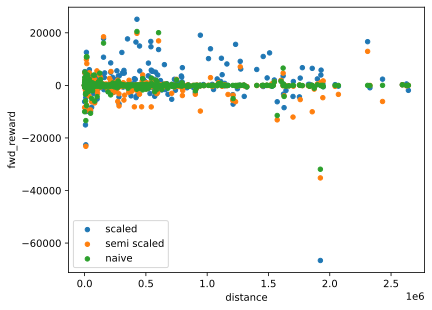

In [46]:
fig, ax = plt.subplots()
non_similar_scaled_df.plot.scatter("distance", "fwd_reward", label="scaled", c="tab:blue", ax=ax)
non_similar_semi_scaled_df.plot.scatter("distance", "fwd_reward", label="semi scaled", c="tab:orange", ax=ax)
non_similar_naive_df.plot.scatter("distance", "fwd_reward", label="naive", c="tab:green", ax=ax)